Binary prediction

In [27]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn import ensemble
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 25
from joblib import dump

1. Data reading and processing

1.1 Data fetch

Read data and retain user characteristics, work characteristics, and whether to like or not. Other invalid fields such as channel (uncertain), finish (non-existent without browsing behavior), H, and date (included in real_time).

In [28]:
df = pd.read_csv('douyin_dataset.csv')
del df['Unnamed: 0'], df['H'], df['date'], df['finish'], df['channel']
df.head()

,uid,user_city,item_id,author_id,item_city,like,music_id,duration_time,real_time
0,15692,109.0,691661,18212,213.0,0,11513.0,10,2019-10-28 21:55:10
1,44071,80.0,1243212,34500,68.0,0,1274.0,9,2019-10-21 22:27:03
2,10902,202.0,3845855,634066,113.0,0,762.0,10,2019-10-26 00:38:51
3,25300,21.0,3929579,214923,330.0,0,2332.0,15,2019-10-25 20:36:25
4,3656,138.0,2572269,182680,80.0,0,238.0,9,2019-10-21 20:46:29


uid and user_city are user information.

item_id, author_id, item_city, music_id, duration_time, and real_time are all information attached to the work.

like predicts whether the target likes or not.

1.2 Data Sampling Processing

To reduce training costs, sample training is performed on the data in the dataset.
Obtain partial browsing information as training data through equidistant sampling (while ensuring a reasonable proportion of like data).

In [29]:
df_like = df[df['like']==1]
df_dislike = df[df['like']==0]
data = pd.concat([df_like[::20], df_dislike[::40]], axis=0)
print(len(data)/len(df))

0.02524186789707318


1.3 Time Data Processing

The real_time field in the training data includes a string object representing a time value, which is converted into a difference (in seconds) from a fixed time for digitization.

In [30]:
flag = pd.to_datetime('2019-01-01 00:00:00')
data['real_time'] = pd.to_datetime(data['real_time'])
data['real_time'] = pd.to_timedelta( data['real_time'] - flag).dt.total_seconds()

In [31]:
data.head()

,uid,user_city,item_id,author_id,item_city,like,music_id,duration_time,real_time
134,32039,2.0,1324665,48937,15.0,1,578.0,10,24181411.0
2181,14571,142.0,2489542,37131,229.0,1,1318.0,7,25305835.0
3955,25090,136.0,1582882,16382,69.0,1,680.0,10,23180382.0
5685,11153,73.0,209250,28248,137.0,1,4545.0,9,24856880.0
8647,2159,106.0,1019916,246,18.0,1,3928.0,9,25677638.0


1.4 Dataset partitioning

In [32]:
xtrain,xtest, ytrain, ytest = \
    train_test_split(
        data.drop('like', axis=1), # X
        data['like'],test_size=0.3, # Y
        random_state=0 # random_seed
    )

2. Model pre training

2.1 Model Training Function

In [33]:
def train(name, model):
    model = model.fit(xtrain, ytrain)
    print(f'{
              name} accuracy: \t{
              model.score(xtest, ytest)}')
    return model

2.2 Model Training

In [34]:
#Logistic regression
lgs = train('lgs', LogisticRegression(solver='liblinear', C=100.0,random_state=1))
#Naive Bayes
gnb = train('gnb', GaussianNB().fit(xtrain,ytrain))
#Single decision tree
clf = train('clf', DecisionTreeClassifier(class_weight='balanced',random_state=0))
#Random Forest
rfc = train('rfc', RandomForestClassifier(n_estimators=100, class_weight='balanced',random_state=0))

lgs accuracy: 	0.9805411979325023
gnb accuracy: 	0.9801611432046214
clf accuracy: 	0.9601702645180906
rfc accuracy: 	0.9805411979325023


In [35]:
#Save the basic model
dump(lgs, 'logistic_regression.joblib')
dump(gnb, 'naive_bayes.joblib')
dump(clf, 'decision_tree.joblib')
dump(rfc, 'random_forest.joblib')

['random_forest.joblib']

2.3 Model AUC Curve

In [36]:
def my_auc(model):
    y_test_proba = model.predict_proba(xtest)
    false_positive_rate, recall, thresholds = roc_curve(ytest, y_test_proba[:, 1])
    roc_auc = auc(false_positive_rate, recall)
    return false_positive_rate, recall, roc_auc

In [37]:
lgs_auc = my_auc(lgs)
gnb_auc = my_auc(gnb)
clf_auc = my_auc(clf)
rfc_auc = my_auc(rfc)

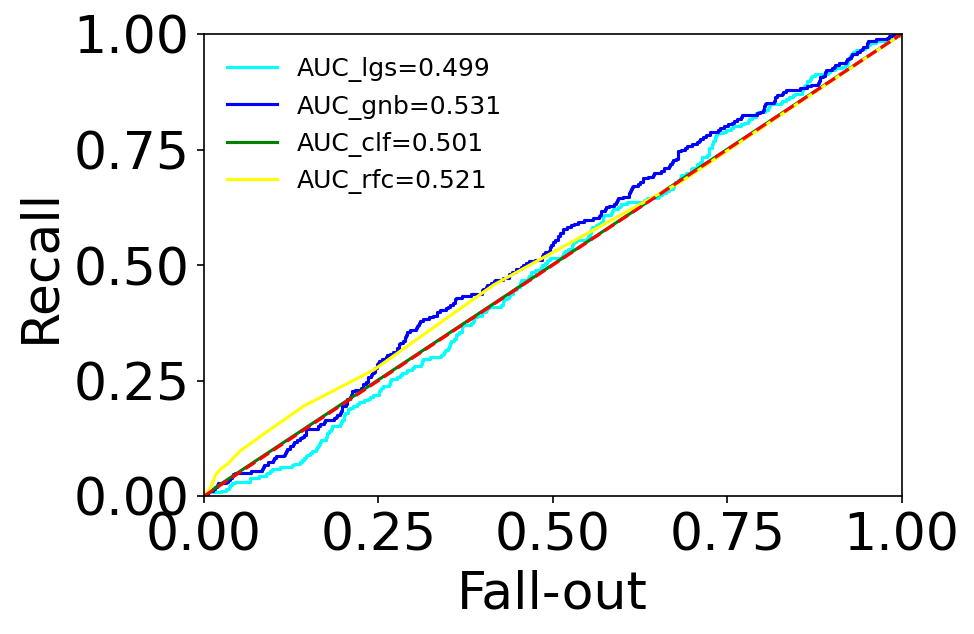

In [38]:
#Draw the ROC curves of two models
plt.figure(figsize=(6,4),dpi=150)
plt.plot(lgs_auc[0], lgs_auc[1], color='cyan', label='AUC_lgs=%0.3f' % lgs_auc[2])
plt.plot(gnb_auc[0], gnb_auc[1], color='blue', label='AUC_gnb=%0.3f' % gnb_auc[2])
plt.plot(clf_auc[0], clf_auc[1], color='green', label='AUC_clf=%0.3f' % clf_auc[2])
plt.plot(rfc_auc[0], rfc_auc[1], color='yellow', label='AUC_rfc=%0.3f' % rfc_auc[2])
plt.legend(loc='best', fontsize=12, frameon=False)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out')
plt.show()

Based on the comprehensive accuracy and AUC value performance, the model's performance is not very good. Expanding the sampling size during data sampling can effectively improve the AUC value. At the same time, the uneven distribution of data with likes and dislikes is also an important reason.

This is only a demonstration of the continuation method. Compared to other methods, random forests have better performance, so random forests are chosen as the binary classification model.

3. Model optimization

Using the GridSearchCV module for grid optimization can be understood as each training parameter being a dimension of the table. Based on the input values, each parameter combination in the grid is traversed, and finally the optimal combination is told to you.
Generally speaking, inputting multiple model parameters directly is sufficient, but the combination of multiple dimensional parameters can lead to a significant increase in the number of training models.
Here, 9 values of n_e and 10 values of max_f were traversed, and with cv=3 requiring a three fold crossover, resulting in 270 training iterations of 9x10x3.
A reasonable solution is decoupling, which reduces the training workload by separating and optimizing the two parameters, achieving relatively good but not optimal results.

3.1 n_e optimization

In [39]:
params = {            
    'n_estimators': [x for x in range(100,1500,100)]
}
grid = GridSearchCV(
    RandomForestClassifier(class_weight='balanced', random_state=0),
    params, scoring="roc_auc",
    cv=3, verbose=1, n_jobs=-1
).fit(xtrain, ytrain)

Fitting 3 folds for each of 14 candidates, totalling 42 fits


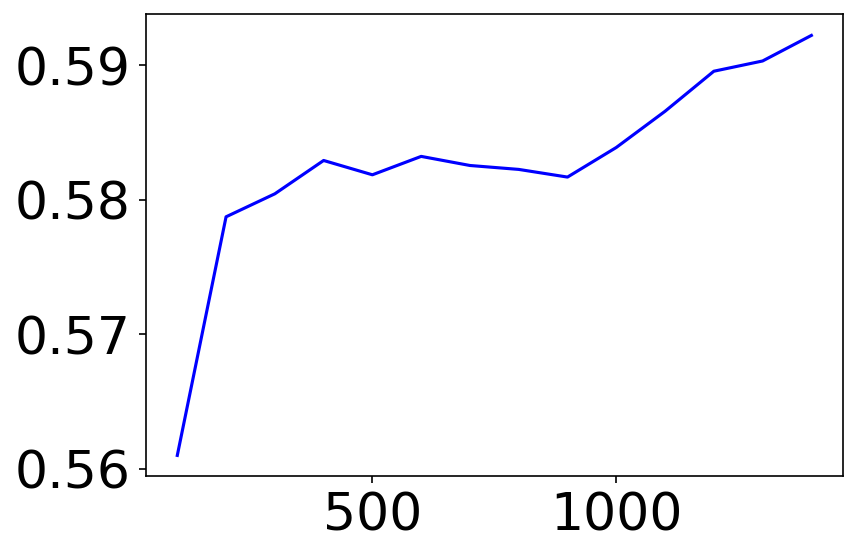

In [40]:
a = grid.cv_results_['mean_test_score']
plt.figure(figsize=(6,4),dpi=150)
plt.plot(params['n_estimators'], a, color='blue')
plt.show()

In [41]:
grid.best_params_

{'n_estimators': 1400}

In [42]:
params = {
            
    'max_features': range(2,10,2)
}
grid = GridSearchCV(
    RandomForestClassifier(n_estimators=1400, class_weight='balanced', random_state=0),
    params, scoring="roc_auc",
    cv=3, verbose=1, n_jobs=-1
).fit(xtrain, ytrain)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


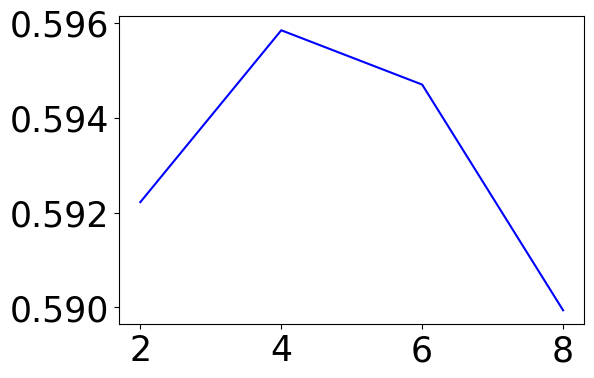

In [43]:
a = grid.cv_results_['mean_test_score']
plt.figure(figsize=(6,4),dpi=100)
plt.plot(params['max_features'], a, color='blue')
plt.show()

In [44]:
grid.best_params_

{'max_features': 4}

In [45]:
rfc0 = RandomForestClassifier(n_estimators=1400,max_features=4,class_weight='balanced',random_state=0)
rfc0 = train('rfc++', rfc0)

rfc++ accuracy: 	0.9805411979325023


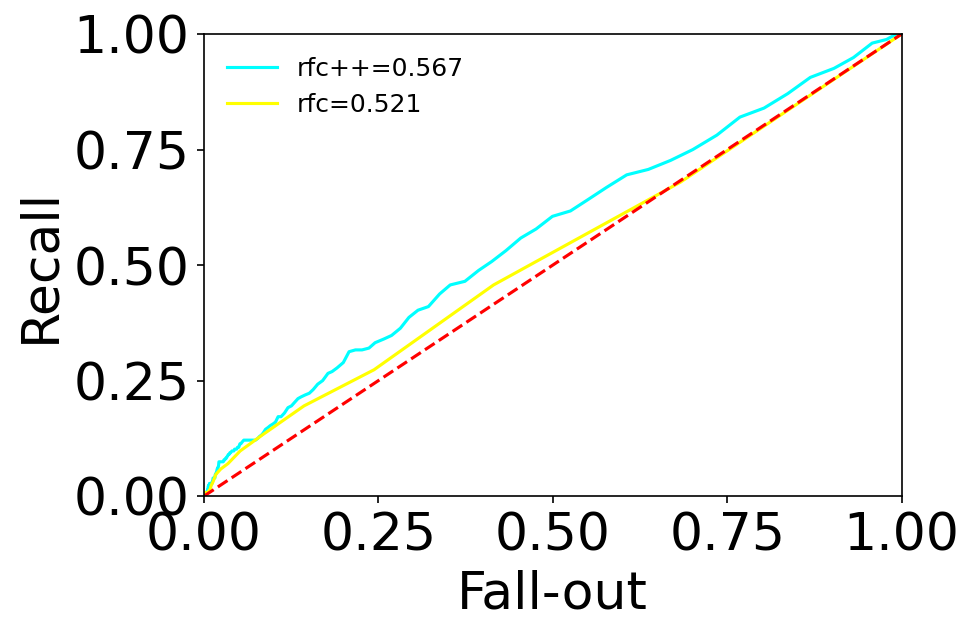

In [46]:
auc_rfc0 = my_auc(rfc0)
#Draw the ROC curves of two models
plt.figure(figsize=(6,4),dpi=150)
plt.plot(auc_rfc0[0], auc_rfc0[1], color='cyan', label='rfc++=%0.3f' % auc_rfc0[2])
plt.plot(rfc_auc[0], rfc_auc[1], color='yellow', label='rfc=%0.3f' % rfc_auc[2])
plt.legend(loc='best', fontsize=12, frameon=False)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out')
plt.show()

In [47]:
dump(rfc0, 'optimized_random_forest.joblib')  #Save optimized random forest
dump(grid.best_estimator_, 'grid_search_model.joblib')  #Save the best model for grid search

['grid_search_model.joblib']

Compared with before and after optimization, although the overall effect is not good and the AUC value is relatively low, it can be seen that there is an improvement in optimization.

4. Model prediction

4.1 Model accuracy

In [48]:
df.head()

,uid,user_city,item_id,author_id,item_city,like,music_id,duration_time,real_time
0,15692,109.0,691661,18212,213.0,0,11513.0,10,2019-10-28 21:55:10
1,44071,80.0,1243212,34500,68.0,0,1274.0,9,2019-10-21 22:27:03
2,10902,202.0,3845855,634066,113.0,0,762.0,10,2019-10-26 00:38:51
3,25300,21.0,3929579,214923,330.0,0,2332.0,15,2019-10-25 20:36:25
4,3656,138.0,2572269,182680,80.0,0,238.0,9,2019-10-21 20:46:29


Convert the time in df and see how accurate the model trained with around 2.5% data can be.

In [49]:
flag = pd.to_datetime('2019-01-01 00:00:00')
df['real_time'] = pd.to_datetime(df['real_time'])
df['real_time'] = pd.to_timedelta( df['real_time'] - flag).dt.total_seconds()

In [50]:
rfc0.score(df.drop('like', axis=1), df['like'])

0.9906504991619237

4.2 Some explanations

In [51]:
lk = df['like'].value_counts()
lk

like
0    1720539
1      16773
Name: count, dtype: int64

In [52]:
lk[0]/lk.sum()

0.9903454301817981

On the surface, the accuracy is relatively high, but let's take a look at the proportion of data that is not liked. 

That is, as long as all predictions are not liked, there can still be an accuracy of 99.03. The model is slightly more accurate, which is okay, but the low AUC value is a weakness

The prediction accuracy of this model is as high as 99%, indicating that a binary classification model can be trained to predict whether users will like based on user features and work features. Whether users like a work during the browsing process is a very important indicator. By liking, we can determine users' preferences and evaluate the quality of their works. And this model can be applied to provide self media companies with a means of content optimization and advertising placement.